# Educación e inclusión en la industria de la tecnología en países hispanos

#### Temática

El foco de la investigación respecto a la educación será entre la **educación tradicional** (escuelas, universidades, etc.) vs. la **educación NO tradicional** (autodidacta, online, etc.) y su impacto en el empleo y salario.

También se abordará el punto de vista de la **inclusión**.

Esta investigación está centrada en los **países hispanos y Brasil**.

#### Data: [encuesta 2021 de Stack Ovelfow](https://insights.stackoverflow.com/survey)

#### Detalles técnicos

Para realizar las pruebas de hipótesis, se utilizará la librería [hypothesize](https://alcampopiano.github.io/hypothesize/function_guide/#pb2gen). Esta librería tiene 2 funciones especiales que la hacen a prueba de distribuciones no normales:

- Prueba de hipótesis con bootstrap
- Trim mean (se la usará al 20%)

- Relacionar años que tomó aprender a programar profesional vs. cómo aprendió a programar o si tiene título
- Poner los insights de salarios por título

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import os
from scipy import stats
from hypothesize.utilities import trim_mean
from hypothesize.compare_groups_with_single_factor import pb2gen

In [2]:
# Read de data
path = os.path.join(os.getcwd(), os.pardir, 'data', 'processed')
df = pd.read_csv(os.path.join(path, 'survey.csv'))

In [3]:
# Set styles
sns.set_theme()
pio.templates.default = 'ggplot2'

## 1. ¿Si voy a la universidad, es más probable que consiga empleo?

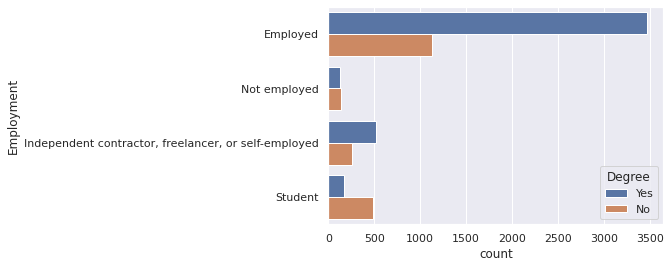

In [4]:
sns.countplot(y=df.Employment, hue=df.Degree)
plt.show()

- Hay un porcentaje importante de personas que no tienen título porque son estudiantes aún
- De las personas que no tienen empleo, hay más que no tienen título

In [5]:
# No sé cómo probar esto. Idea: stats.chi2

### 2. ¿Si tengo título gano más que si no?

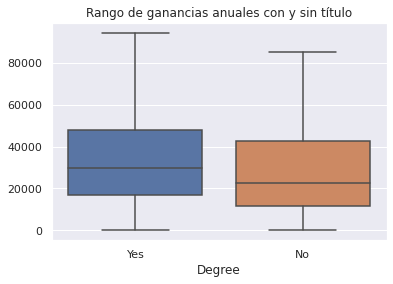

In [6]:
sns.boxplot(x=df.Degree, y=df.ConvertedCompYearly, showfliers=False)
plt.title('Rango de ganancias anuales con y sin título')
plt.ylabel(None)
plt.show()

##### Establecer la hipótesis nula:
- **Hipótesis nula (Ho):** los salarios _son los mismos_ para personas con o sin título.
- **Hipótesis alternativa (Ha):** los salarios son _más altos_ para personas con título.

##### Estadístico de prueba:
- Resta de las timmed means 0.2

In [7]:
# Diferencia entre las ganancias anuales
s_has_degree = df.ConvertedCompYearly[(df.Degree == 'Yes') & (df.ConvertedCompYearly.notnull())]
s_not_degree = df.ConvertedCompYearly[(df.Degree == 'No') & (df.ConvertedCompYearly.notnull())]

In [8]:
# Test if has a normal distribution
print(stats.shapiro(s_has_degree))
print(stats.shapiro(s_not_degree))

ShapiroResult(statistic=0.20545274019241333, pvalue=0.0)
ShapiroResult(statistic=0.17611545324325562, pvalue=0.0)


El test de `shapiro` confirma que las distribuciones no son normales, no se puede aplicar `stats.ttest_ind`. En cambio, se aplica `hypothesize.pb2gen` que usa bootstrap.

In [9]:
pb2gen(s_has_degree, s_not_degree, trim_mean, .2)

{'est_1': 31090.308467741936,
 'est_2': 24916.923312883435,
 'est_dif': 6173.385154858501,
 'ci': [4466.815041806847, 7874.840790743121],
 'p_value': 0.0,
 'variance': 793693.0102081028,
 'n1': 3304,
 'n2': 1084}

Se rechaza la hipótesis nula. Las personas con título tienden a ganar más anualmente.

### 2. ¿Si aprendo código solo de la manera tradicional gano más que si no?

- **Hipótesis nula (Ho):** los salarios _son los mismos_ para personas que aprendieron código de manera tradicional y no tradicional.
- **Hipótesis alternativa (Ha):** los salarios son _más altos_ para personas que aprendieron código de manera tradicional.

In [10]:
# Reduzco los datos a: aprendio de forma tradicional o no
df_learn = pd.DataFrame()
df_learn['LearnTraditional'] = df.LearnCode.where(df.LearnCode == 'Traditional', 'No')
df_learn.LearnTraditional.replace('Traditional', 'Yes', inplace = True)
df_learn['Salary'] = df.ConvertedCompYearly

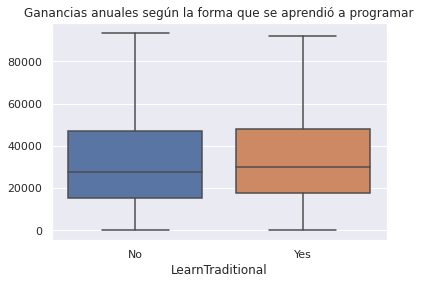

In [11]:
sns.boxplot(x=df_learn.LearnTraditional, y=df_learn.Salary, showfliers=False)
plt.title('Ganancias anuales según la forma que se aprendió a programar')
plt.ylabel(None)
plt.show()

In [12]:
traditional = df_learn.Salary[df_learn.LearnTraditional == 'Yes'].dropna()
not_traditional = df_learn.Salary[df_learn.LearnTraditional == 'No'].dropna()

In [13]:
pb2gen(traditional, not_traditional, trim_mean, 0.2, nboot=10000)

{'est_1': 31161.80149812734,
 'est_2': 29456.776087874947,
 'est_dif': 1705.025410252394,
 'ci': [-567.2604918756515, 4161.117846987843],
 'p_value': 0.1548,
 'variance': 1483221.7473584698,
 'n1': 445,
 'n2': 3943}

Con un p-value de 15% no se puede rechazar Ho. Es probable que la pequeña diferencia que se ve en la gráfica que haya dado por azar, no se puede asegurar que se gana más si se aprende código únicamente de manera tradicional.

### 3. ¿Gano más si aprendo de manera no tradicional?

- **Hipótesis nula (Ho):** los salarios _son los mismos_ para personas que aprendieron código de manera tradicional y no tradicional.
- **Hipótesis alternativa (Ha):** los salarios son _más altos_ para personas que aprendieron código de manera no tradicional.

In [14]:
df_learn['LearnNoTraditional'] = df.LearnCode.where(df.LearnCode == 'Non-traditional', 'No')
df_learn.LearnNoTraditional.replace('Non-traditional', 'Yes', inplace = True)

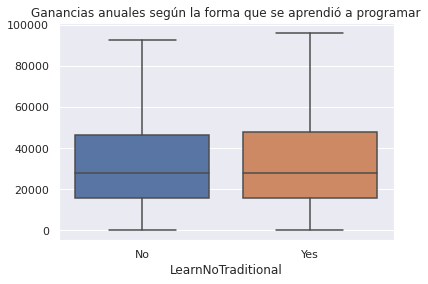

In [15]:
sns.boxplot(x=df_learn.LearnNoTraditional, y=df_learn.Salary, showfliers=False)
plt.title('Ganancias anuales según la forma que se aprendió a programar')
plt.ylabel(None)
plt.show()

In [16]:
not_traditional = df_learn.Salary[df_learn.LearnNoTraditional == 'Yes'].dropna()
traditional = df_learn.Salary[df_learn.LearnNoTraditional == 'No'].dropna()

In [17]:
pb2gen(not_traditional, traditional, trim_mean, 0.2, nboot=10000)

{'est_1': 29769.08839354343,
 'est_2': 29515.11027756939,
 'est_dif': 253.9781159740378,
 'ci': [-1217.151652632605, 1725.2150604907183],
 'p_value': 0.7556,
 'variance': 569781.8361722651,
 'n1': 2167,
 'n2': 2221}

Tampoco se puede rechazar la hipótesis nula. No hay significancia estadística como para asegurar que hay una diferencia de salarios según el tipo de forma que se aprendió a programar.

### 4. ¿Los hombres ganan más que las mujeres?

- Hipótesis nula (Ho): los salarios son los mismos para hombres y mujeres.
- Hipótesis alternativa (Ha): los salarios son más altos para los hombres.

In [18]:
man_salary = df[df['Gender'] == 'Man']['ConvertedCompYearly'].dropna()
woman_salary = df[df['Gender'] == 'Woman']['ConvertedCompYearly'].dropna()

In [19]:
t_mw = pb2gen(man_salary, woman_salary, trim_mean, 0.2, nboot=10000)
if t_mw['p_value'] < 0.01:
    print(f'p-value = {t_mw["p_value"]}, se rechaza Ho. Los salarios son más altos para los hombres')
t_mw

p-value = 0.0024, se rechaza Ho. Los salarios son más altos para los hombres


{'est_1': 30000.73607748184,
 'est_2': 24399.78,
 'est_dif': 5600.956077481842,
 'ci': [2101.6731638418096, 8881.445318805487],
 'p_value': 0.0024,
 'variance': 3021523.938215595,
 'n1': 4128,
 'n2': 164}

### 5. ¿Los heteros ganan más que el resto de personas?

- Hipótesis nula (Ho): los salarios son los mismos para todas las personas.
- Hipótesis alternativa (Ha): los salarios son más altos para los heteros.

In [20]:
hetero_salary = df[df['Sexuality'] == 'Straight / Heterosexual']['ConvertedCompYearly'].dropna()
non_hetero_salary = df[df['Sexuality'] == 'LGBT / Non-hetero']['ConvertedCompYearly'].dropna()

In [21]:
pb2gen(hetero_salary, non_hetero_salary, trim_mean, 0.2, nboot=10000)

{'est_1': 30192.351523419737,
 'est_2': 26890.55172413793,
 'est_dif': 3301.7997992818055,
 'ci': [1320.783048721205, 5164.246761066941],
 'p_value': 0.0018,
 'variance': 965983.9922074673,
 'n1': 3665,
 'n2': 723}

Se rechaza Ho. Los heteros ganan más que los no heteros.

## Preguntas para prueba de hipótesis

1. ¿Si voy a la universidad, es más probable que consiga empleo?
1. ¿Si tengo título gano más que si no?
2. ¿Si aprendo código solo de la manera tradicional gano más que si no?
3. ¿Gano más si aprendo combinando tradicional y no tradicional?
5. Misma pregunta pero para rangos de edad bajos

Extra:
¿Por qué primary school está en el top y secundary school al final?


#### Preguntas posibles relacionadas al tema

- Education lvl vs. dónde aprendió a programar
- Salarios por rango de edad
- Salarios según dónde se aprendió a programar
- ¿Si tengo título gano más que si no?
- Qué cargos tienes según dónde estudiaste
- Cuánto tiempo te tomó desde que aprendiste código hasta que programaste profesionalmente? (dónde aprendiste a programar)
- Las personas que aprendieron a programar más jóvenes, ganan más? Qué puesto tienen? (contestar según rangos de edad)


#### Otras preguntas

- Diferencia de salario entre trans y heteros (y si fueron a las universidades)?
- Diferencia de salario entre hombres y mujeres -> Hombres ganan mucho más en promedio y la probabilidad de que esto sea random es baja.
- Lenguajes de programación aprendidos por tipo de aprendizaje

- Extraer algo para mejorar esto y cerrar la brecha

#### Accionables:
- Cómo disminuir esta brecha de género

#### To-Do
- Dividir el análisis por partes o por preguntas
- Crear una (o varias) función para plotear
- Crear un notebook con el código escondido, que sea solo de reporte y gráficas

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=09491c61-3767-4289-98fd-88aee19bb45d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>